In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                
from nltk import word_tokenize, sent_tokenize
import re
# from nltk.stem import WordNetLemmatizer # 同义词转述
from nltk.stem import WordNetLemmatizer # 同义词转述

import keras
from keras import models
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,load_model
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from keras.layers import Dropout , Activation, GRU, TimeDistributed,Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D,MaxPooling1D,AveragePooling1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

from keras import backend as K

import gensim
from gensim.models import Word2Vec

from keras.engine.topology import Layer, InputSpec

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
!ls '../input/'

imdb-review-dataset  kumarmanoj-bag-of-words-meets-bags-of-popcorn


In [3]:
# import os
# print(os.listdir())

raw_train_data_labeled = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
raw_train_data_unlabeled = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
raw_test_data = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/testData.tsv", header=0, delimiter="\t", quoting=3)

imdb_data = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding="latin-1", index_col=0)
print(len(imdb_data))

imdb_data = imdb_data.drop(["type","file"],axis=1)
imdb_data['sentiment'] = imdb_data['label'].map({"neg":0, "pos":1})
imdb_data = imdb_data.drop(["label",'sentiment'],axis=1)
# imdb_data = imdb_data.dropna() # 删除缺失数据
raw_train_data_labeled = raw_train_data_labeled.drop(["id","sentiment"],axis=1)
raw_train_data_unlabeled = raw_train_data_unlabeled.drop(["id"],axis=1)
raw_test_data = raw_test_data.drop(["id"],axis=1)
# print(raw_test_data.head())
# = imdb_data['review']

review_data = pd.concat([imdb_data,raw_train_data_unlabeled,raw_train_data_labeled,raw_test_data],ignore_index=True)
print(len(imdb_data))
print(len(review_data))

100000
100000
200000


In [4]:
review_data_2 = imdb_data['review'].append(raw_train_data_unlabeled['review'])
review_data_2 = review_data_2.append(raw_train_data_labeled['review'])
review_data_2 = review_data_2.append(raw_test_data['review'])

type(review_data_2)

pandas.core.series.Series

In [5]:
import string

review_lines = list()
lines = review_data_2.values.tolist()
lemmatizer = WordNetLemmatizer()
# i = 1
for line in lines:
#     i = i + 1
    '''
    breaks line into it's sub parts like each word and comma etc,
    https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    '''
    tokens = word_tokenize(line)   
#     print(tokens)
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] ## 同义词转述

    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if ((w not in stop_words)and(w!='br')and(len(w)>1))]
    
    review_lines.append(words)
    
#     if (i>5):
#         break

In [6]:
import gensim

embedding_vector_size = 150
# now training embeddings for each word 
print('word_2_vector is training ...')
model_word_2_vector = gensim.models.Word2Vec(sentences = review_lines, size=embedding_vector_size, min_count=1, window=5, workers=4 )
print('word_2_vector finished training')
# to get total number of unique words

word_2_vector is training ...
word_2_vector finished training


In [7]:
model_word_2_vector.save('../input/model_word_2_vector_02.model')

In [8]:
type(review_lines)
# review_lines[:2][1]

list

In [9]:
words = list(model_word_2_vector.wv.vocab)

print("vocab size:", len(words))

vocab size: 193254


In [10]:
review_lines = review_lines[150000:]
print(len(review_lines))

50000


117.8178


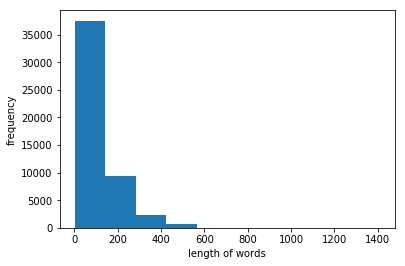

In [11]:
#len(sequence)
leng=0
length = [(leng + len(x)) for x in review_lines]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

import math
avg_length = sum(length)/len(review_lines)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)
max_len = math.ceil(avg_length) 

In [12]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_word_2_vector.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
raw_train_data_labeled = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
raw_test_data = pd.read_csv("../input/kumarmanoj-bag-of-words-meets-bags-of-popcorn/testData.tsv", header=0, delimiter="\t", quoting=3)


print(len(raw_train_data_labeled))
print(len(raw_test_data))

X_train = train_test_data[5000:25000,:]
X_test = train_test_data[:5000,:]
# X = X.reshape(-1,123)
y_train = raw_train_data_labeled['sentiment'][5000:25000]
y_test = raw_train_data_labeled['sentiment'][:5000]

25000
25000


In [14]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        super(AttLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        # W.shape = (time_steps, time_steps)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[1], input_shape[1]),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[1],),
                                 initializer='uniform',
                                 trainable=True)
        super(AttLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, time_steps, seq_len)
        x = K.permute_dimensions(inputs, (0, 2, 1))
        # x.shape = (batch_size, seq_len, time_steps)
        a = K.softmax(K.tanh(K.dot(x, self.W) + self.b))
        outputs = K.permute_dimensions(a * x, (0, 2, 1))
        outputs = K.sum(outputs, axis=1)
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

In [15]:
a_conv1 = Conv1D(32,3,strides=2,activation='relu')

In [16]:
from keras import backend as K
K.set_image_data_format('channels_first')

sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size,
                            embedding_vector_size,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable= True )(sequence_input)

a_conv1 = Conv1D(32,1,strides=2,padding = 'same', activation='relu')(embedded_sequences)

b_conv1 = Conv1D(32,1,padding = 'same',activation='relu')(embedded_sequences)
b_conv2 = Conv1D(32,3,strides=2,padding = 'same',activation='relu')(b_conv1)

c_conv1 = AveragePooling1D(3,strides=2)(embedded_sequences)
c_conv2 = Conv1D(32,3,padding = 'same',activation='relu')(c_conv1)

d_conv1 = Conv1D(32,1,padding = 'same', activation='relu')(embedded_sequences)
d_conv2 = Conv1D(32,3,padding = 'same', activation='relu')(d_conv1)
d_conv3 = Conv1D(32,3,padding = 'same', activation='relu')(d_conv2)

merge = layers.concatenate([a_conv1,b_conv2,c_conv2,d_conv3],axis=1)
gru = Bidirectional(GRU(100, dropout = 0.1, recurrent_dropout=0.1, return_sequences=True))(merge)
att = AttLayer()(gru)
preds = Dense(1, activation='sigmoid')(att)

model = Model(sequence_input, preds)

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])

# model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 118)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 118, 150)     18702000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 118, 32)      4832        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

In [17]:
# y_test

In [18]:
history = model.fit(X_train, 
                    y_train, epochs = 30, 
                    batch_size = 128, 
                    validation_data=(X_test, y_test),
                    callbacks = [learning_rate_reduction]
                   )

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 178s 9ms/step - loss: 0.4632 - acc: 0.7762 - val_loss: 0.4899 - val_acc: 0.7810
Epoch 2/30
20000/20000 [==============================] - 174s 9ms/step - loss: 0.3406 - acc: 0.8538 - val_loss: 0.3612 - val_acc: 0.8378
Epoch 3/30
20000/20000 [==============================] - 173s 9ms/step - loss: 0.2985 - acc: 0.8780 - val_loss: 0.2826 - val_acc: 0.8826
Epoch 4/30
20000/20000 [==============================] - 171s 9ms/step - loss: 0.2750 - acc: 0.8865 - val_loss: 0.3167 - val_acc: 0.8670
Epoch 5/30
20000/20000 [==============================] - 168s 8ms/step - loss: 0.2513 - acc: 0.9012 - val_loss: 0.3865 - val_acc: 0.8366
Epoch 6/30
20000/20000 [==============================] - 170s 8ms/step - loss: 0.2319 - acc: 0.9059 - val_loss: 0.2759 - val_acc: 0.8910
Epoch 7/30
20000/20000 [==============================] - 167s 8ms/step - l

In [19]:
model.save('model_1_w2v_simple.h5')

In [20]:
X_sub = train_test_data[25000:,:]
y_pred = model.predict(X_sub)
y_pred = y_pred.reshape(-1,)
# predictions = [1 if (x>0.5) else 0 for x in y_pred ]
predictions = pd.Series(y_pred)
ids = raw_test_data['id'].str.replace('"', '')
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('submission.csv',index=False)
y_preds = model.predict(X_test)
y_preds = y_preds.reshape(-1,)
x_stack = pd.Series(y_preds)

y_stack = pd.Series(y_test)

In [21]:
sub_stack = pd.DataFrame({'x_stack': x_stack, 'y_stack':y_stack})
sub_stack.to_csv('sub_stack.csv',index=False)

In [22]:
_

list